## Tutorial - Spatiotemporal analysis of videos for task recognition

> How to use fastai to train an image sequence to image sequence job.

In [1]:
# ! pip install rarfile av

In [2]:
# ! pip install -Uq pyopenssl

In [1]:
from fastai.vision.all import *

In [4]:
# wget https://raw.githubusercontent.com/fastai/fastsetup/master/setup-conda.sh -P ~/.fastai/archive/ --no-check-certificate  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar 

In [2]:
from rarfile import RarFile
    
def unrar(fname, dest):
    "Extract `fname` to `dest` using `rarfile`"
    dest = URLs.path(c_key='data')/fname.name.withsuffix('') if dest is None else dest
    print(f'extracting to: {dest}')
    if not dest.exists():
        fname = str(fname)
        if fname.endswith('rar'):  
            with RarFile(fname, 'r') as myrar:
                myrar.extractall(dest.parent)
        else: 
            raise Exception(f'Unrecognized archive: {fname}')
        rename_extracted(dest)
    return dest

In [3]:
ucf_fname = Path.home()/'.fastai/archive/UCF101.rar'
dest = Path.home()/'.fastai/data/UCF101'

In [4]:
# path = unrar(ucf_fname, dest)

In [5]:
path = Path('/home/bilal/.fastai/data/UCF101')
path.ls()

(#101) [Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping'),Path('/home/bilal/.fastai/data/UCF101/ParallelBars'),Path('/home/bilal/.fastai/data/UCF101/PlayingTabla'),Path('/home/bilal/.fastai/data/UCF101/SoccerJuggling'),Path('/home/bilal/.fastai/data/UCF101/Haircut'),Path('/home/bilal/.fastai/data/UCF101/JugglingBalls'),Path('/home/bilal/.fastai/data/UCF101/Skiing'),Path('/home/bilal/.fastai/data/UCF101/HandstandWalking'),Path('/home/bilal/.fastai/data/UCF101/BreastStroke'),Path('/home/bilal/.fastai/data/UCF101/PullUps')...]

In [6]:
video_paths = get_files(path, extensions='.avi')
video_paths[0:4]

(#4) [Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping/v_TrampolineJumping_g09_c04.avi'),Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping/v_TrampolineJumping_g20_c05.avi'),Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping/v_TrampolineJumping_g24_c02.avi'),Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping/v_TrampolineJumping_g15_c03.avi')]

In [7]:
import av

In [8]:
def extract_frames(video_path):
    "convert video to PIL images "
    video = av.open(str(video_path))
    for frame in video.decode(0):
        yield frame.to_image()

In [9]:
frames = list(extract_frames(video_paths[0]))
frames[0:4]

[<PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>,
 <PIL.Image.Image image mode=RGB size=320x240>]

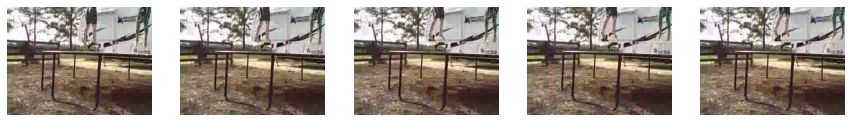

In [10]:
show_images(frames[0:5])

In [11]:
video_path = video_paths[0]
video_path

Path('/home/bilal/.fastai/data/UCF101/TrampolineJumping/v_TrampolineJumping_g09_c04.avi')

In [12]:
video_path.relative_to(video_path.parent.parent).with_suffix('')

Path('TrampolineJumping/v_TrampolineJumping_g09_c04')

In [13]:
path_frames = path.parent/'UCF101-frames'
if not path_frames.exists(): path_frames.mkdir()

In [14]:
def avi2frames(video_path, path_frames=path_frames, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not dest_path.exists() or force:
        dest_path.mkdir(parents=True, exist_ok=True)
        for i, frame in enumerate(extract_frames(video_path)):
            frame.save(dest_path/f'{i}.jpg')

In [15]:
avi2frames(video_path)
(path_frames/video_path.relative_to(video_path.parent.parent).with_suffix('')).ls()

(#201) [Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/118.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/140.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/1.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/178.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/11.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/124.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/72.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/183.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c04/20.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g09_c

In [16]:
# parallel(avi2frames, video_paths)

In [17]:
data_path = Path.home()/'.fastai/data/UCF101-frames'
data_path.ls()[0:3]

(#3) [Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping'),Path('/home/bilal/.fastai/data/UCF101-frames/ParallelBars'),Path('/home/bilal/.fastai/data/UCF101-frames/PlayingTabla')]

In [18]:
def get_instances(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

In [19]:
instances_path = get_instances(data_path)
instances_path[0:3]

(#3) [Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g24_c03'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g14_c03')]

In [20]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [21]:
instances_path[0].ls_sorted()

(#296) [Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/0.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/1.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/2.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/3.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/4.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/5.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/6.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/7.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/8.jpg'),Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02/9.jpg')...

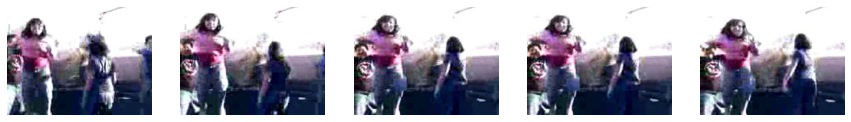

In [22]:
frames = instances_path[0].ls_sorted()[0:5]
show_images([Image.open(img) for img in frames])

In [23]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

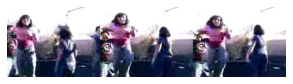

In [24]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

In [25]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [26]:
tfm = ImageTupleTfm(seq_len=5)
hammering_instance = instances_path[0]
hammering_instance

Path('/home/bilal/.fastai/data/UCF101-frames/TrampolineJumping/v_TrampolineJumping_g08_c02')

<AxesSubplot:>

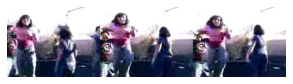

In [27]:
tfm(hammering_instance).show()

In [28]:
parent_label(hammering_instance)

'TrampolineJumping'

In [29]:
splits = RandomSplitter()(instances_path)

In [30]:
ds = Datasets(instances_path, tfms=[[ImageTupleTfm(5)], [parent_label, Categorize]], splits=splits)

In [31]:
len(ds)

13320

In [32]:
dls = ds.dataloaders(bs=4, after_item=[Resize(128), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [33]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

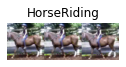

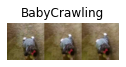

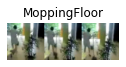

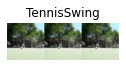

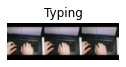

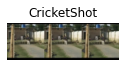

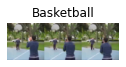

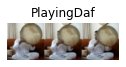

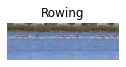

In [34]:
dls = get_action_dataloaders(instances_path, bs=32, image_size=64, seq_len=5)
dls.show_batch()

In [35]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34, n_out=101):
        self.encoder = TimeDistributed(create_body(arch, pretrained=True))
        self.head = TimeDistributed(create_head(512, 101))
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)
    
def simple_splitter(model): return [params(model.encoder), params(model.head)]

In [36]:
model = SimpleModel().cuda()

In [37]:
x,y = dls.one_batch()

In [38]:
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }, \n{model(x).shape = }')

type(x) = <class '__main__.ImageTuple'>,
len(x) = 5 ,
x[0].shape = torch.Size([32, 3, 64, 64]), 
model(x).shape = torch.Size([32, 101])


In [39]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

In [40]:
learn = Learner(dls, model, metrics=[accuracy], splitter=simple_splitter).to_fp16()

SuggestedLRs(valley=0.0002754228771664202)

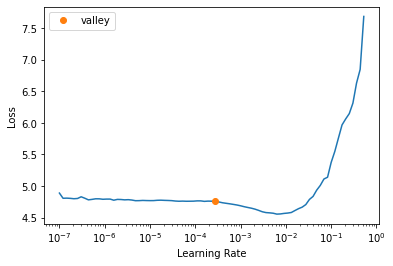

In [41]:
learn.lr_find()

In [42]:
learn.fine_tune(3, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,3.710426,3.259879,0.305556,00:21
1,2.477154,2.108346,0.479730,00:21
2,1.961732,1.675768,0.570946,00:21


epoch,train_loss,valid_loss,accuracy,time
0,1.513818,1.405228,0.640766,00:22
1,1.123580,1.172312,0.703453,00:22
2,0.930497,1.132517,0.712838,00:23


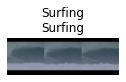

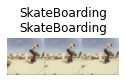

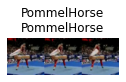

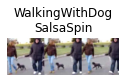

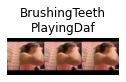

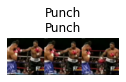

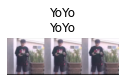

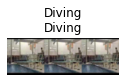

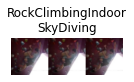

In [43]:
learn.show_results()

In [44]:
arch = resnet34
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

In [45]:
encoder(x[0]).shape

torch.Size([32, 512])

In [46]:
tencoder = TimeDistributed(encoder)
tencoder(torch.stack(x, dim=1)).shape

torch.Size([32, 5, 512])

In [47]:
class RNNModel(Module):
    def __init__(self, arch=resnet34, n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [48]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [49]:
model2 = RNNModel().cuda()

In [50]:
learn = Learner(dls, model2, metrics=[accuracy], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(valley=0.0002754228771664202)

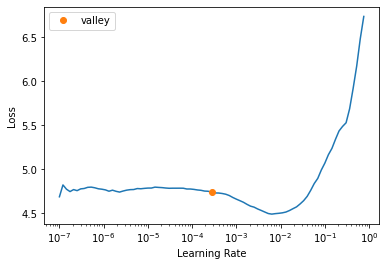

In [51]:
learn.lr_find()

In [52]:
learn.fine_tune(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.027482,3.006760,0.284910,00:21


epoch,train_loss,valid_loss,accuracy,time
0,1.910170,1.910230,0.516141,00:23
1,1.497595,1.466113,0.619745,00:23
2,0.997165,1.115087,0.712087,00:23
3,0.528439,0.899086,0.772523,00:23
4,0.357998,0.872218,0.786036,00:23


In [53]:
!pip install -Uq timesformer-pytorch

In [54]:
from timesformer_pytorch import TimeSformer

In [55]:
class MyTimeSformer(TimeSformer):
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return super().forward(x)

In [56]:
timesformer = MyTimeSformer(
    dim = 128,
    image_size = 128,
    patch_size = 16,
    num_frames = 5,
    num_classes = 101,
    depth = 12,
    heads = 8,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).cuda()

In [57]:
learn_tf = Learner(dls, timesformer, metrics=[accuracy]).to_fp16()

SuggestedLRs(valley=0.00010964782268274575)

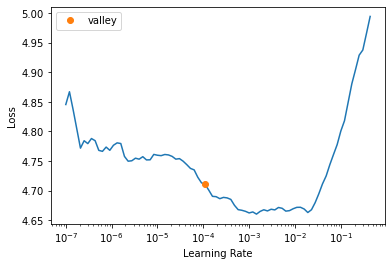

In [58]:
learn_tf.lr_find()

In [59]:
learn_tf.fit_one_cycle(12, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.146832,4.049287,0.100976,01:01
1,3.680707,3.626314,0.158408,00:59
2,3.245397,3.185885,0.224474,00:59
3,2.614939,2.603741,0.352477,00:59
4,1.966003,2.171075,0.452703,00:59
5,1.290122,1.662016,0.582583,01:00
6,0.851964,1.309661,0.674925,01:01
7,0.445399,1.110009,0.730105,00:59
8,0.232653,1.055463,0.749625,00:59
9,0.121251,1.008655,0.765015,01:00


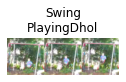

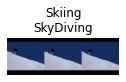

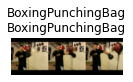

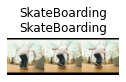

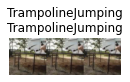

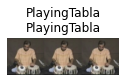

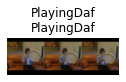

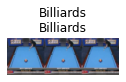

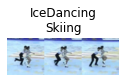

In [60]:
learn_tf.show_results()